# Data process

In [1]:
import os
import subprocess
import gzip
import io
import json
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk.data

In [2]:
# Find sentence-citataion pairs that have more than 10 words in the sentence

def find_pair(textl, bibl):
    pair_dict = {}
    for para in textl:
        cite_list = para['cite_spans']
        text = para['text']
        for cite in cite_list:
            start = int(cite['start'])
            end = int(cite['end'])
            # If cite_spans out of the sentence
            if text[start-2] in ['.', '!', '?']:
                i = start-3
                while i >= 0:
                    if text[i] in ['.', '!', '?']:
                        break
                    i = i - 1
                while i <= start-2:
                    if re.match("[A-Z]", text[i]) == None:
                        i = i + 1
                    else:
                        break
                sentence = text[i:start-1]
                sentence_len = len(sentence.split(' '))
                ref_id = cite['ref_id']
                bib_id = bibl.get(ref_id, 'not exist')
                if bib_id == 'not exist':
                    paper_id = None
                else:
                    paper_id = bibl[ref_id]['link']
                if paper_id != None and sentence_len >= 10:
                    pair_dict[paper_id] = sentence
                    
            # If cite_spans in the sentence
            if end + 1 < len(text):
                if text[end+1] in ['.', '!', '?']:
                    i = start-1
                    while i >= 0:
                        if text[i] in ['.', '!', '?']:
                            break
                        i = i - 1
                    while i <= start-2:
                        if re.match("[A-Z]", text[i]) == None:
                            i = i + 1
                        else:
                            break
                    sentence = text[i:end+2]
                    sentence_len = len(sentence.split(' '))
                    ref_id = cite['ref_id']
                    bib_id = bibl.get(ref_id, 'not exist')
                    if bib_id == 'not exist':
                        paper_id = None
                    else:
                        paper_id = bibl[ref_id]['link']
                    if paper_id != None and sentence_len >= 10:
                        pair_dict[paper_id] = sentence
    
    return pair_dict

In [3]:
def data_preprocessor(df_meta, df_pdf):
    
    # Collect title and abstract

    df = pd.DataFrame(df_meta.loc[:, 'title'])
    for i in df.index:
        if i in df_pdf.index:
            if df_pdf.at[i, 'abstract'] != [] and df_pdf.at[i, 'abstract'] != '':
                df.at[i, 'abstract'] = df_pdf.at[i, 'abstract'][0]['text']

    df.replace('', np.nan, inplace=True)
    df = df.dropna()

    # Collect full text

    for i in df.index:
        if i in df_pdf.index:
            full_text = ''
            for sec in df_pdf.loc[i,'body_text']:
                if sec['text'] != [] and sec['text'] != '':
                    full_text += sec['text']
            df.at[i, 'full_text'] = df.loc[i, 'abstract'] + full_text
            
    # Collect body text

    for i in df.index:
        if i in df_pdf.index:
            body_text = ''
            for sec in df_pdf.loc[i,'body_text']:
                if sec['text'] != [] and sec['text'] != '' and sec['section'].lower() != 'related work':
                    body_text += sec['text']
            df.at[i, 'body_text'] = body_text
            
    # Collect related work text
    ### WARNING: REPLACE 'introduction' with 'related_work'

    for i in df.index:
        if i in df_pdf.index:
            related_work_text = ''
            for sec in df_pdf.loc[i,'body_text']:
                if sec['section'].lower() == 'related work' and sec['text'] != '' and sec['text'] != []:
                    related_work_text += sec['text']
            df.at[i, 'related_work_text'] = related_work_text

    # Remove papers that don't have related work sections  
    df['related_work_text'].replace('', np.nan, inplace=True)
    df = df.dropna()

    # Collect sentence-citation pairs in related work text and body text
    ### WARNING: REPLACE 'introduction' with 'related_work'

    for i in df.index:
        if i in df_pdf.index:
            full_textl = df_pdf.at[i, 'body_text']
            related_work_textl = []
            body_textl = []
            bibl = df_pdf.at[i, 'bib_entries']
            for t in full_textl:
                if t['section'].lower() == 'related work':
                    related_work_textl.append(t)
                else:
                    body_textl.append(t)
            related_work_pairs = find_pair(related_work_textl, bibl)
            body_pairs = find_pair(body_textl, bibl)
            df.at[i, 'related_work_pairs'] = i # without this line, there will be an error. But I'm not sure about the reason
            df.at[i, 'related_work_pairs'] = related_work_pairs

            df.at[i, 'body_pairs'] = i # without this line, there will be an error. But I'm not sure about the reason
            df.at[i, 'body_pairs'] = body_pairs

    # Remove papers that don't have citations in related work sections and body texts        
    data_processed = df.loc[(df.body_pairs != {}) & (df.related_work_pairs != {})]
    
    pd.options.mode.chained_assignment = None
            
    # Remove papars that have fewer than four citation in the related work section
    for i in data_processed.index:
        data_processed.at[i, 'length'] = int(len(data_processed.loc[i, 'related_work_pairs']))
    data_processed = data_processed.loc[data_processed.length > 4].iloc[:, :7]        
            
    return data_processed

In [4]:
meta_dir = '../dataset/SS/metadata/CS/'
pdf_dir = '../dataset/SS/pdf_parses/CS/'

meta_files = os.listdir(meta_dir)
pdf_files = os.listdir(pdf_dir)


for i in np.arange(len(meta_files)):
    
    meta_list = []
    
    with open(os.path.join(meta_dir, meta_files[i]), 'r') as json_file:
        json_list = list(json_file)
        
        for json_str in json_list:
            result = json.loads(json_str)
            meta_list.append(result)
        
    pdf_list = []

    with open(os.path.join(pdf_dir, pdf_files[i]), 'r') as json_file:
        json_list = list(json_file)
        
        for json_str in json_list:
            result = json.loads(json_str)
            pdf_list.append(result) 
            
    df_meta = pd.DataFrame(meta_list)
    df_meta = df_meta.set_index('paper_id')
    
    df_pdf = pd.DataFrame(pdf_list)
    df_pdf = df_pdf.set_index('paper_id')
    
    data_processed = data_preprocessor(df_meta, df_pdf)
    
    if i == 0:
        df = data_processed
        print(pdf_files[i], 'filtered')
    else:
        df = df.append(data_processed)
        print(pdf_files[i], 'filtered')

pdf_parses_0.jsonl filtered
pdf_parses_1.jsonl filtered
pdf_parses_10.jsonl filtered
pdf_parses_11.jsonl filtered
pdf_parses_12.jsonl filtered
pdf_parses_13.jsonl filtered
pdf_parses_14.jsonl filtered
pdf_parses_15.jsonl filtered
pdf_parses_16.jsonl filtered
pdf_parses_17.jsonl filtered
pdf_parses_18.jsonl filtered
pdf_parses_19.jsonl filtered
pdf_parses_2.jsonl filtered
pdf_parses_20.jsonl filtered
pdf_parses_21.jsonl filtered
pdf_parses_22.jsonl filtered
pdf_parses_23.jsonl filtered
pdf_parses_24.jsonl filtered
pdf_parses_25.jsonl filtered
pdf_parses_26.jsonl filtered
pdf_parses_27.jsonl filtered
pdf_parses_28.jsonl filtered
pdf_parses_29.jsonl filtered
pdf_parses_3.jsonl filtered
pdf_parses_30.jsonl filtered
pdf_parses_31.jsonl filtered
pdf_parses_32.jsonl filtered
pdf_parses_33.jsonl filtered
pdf_parses_34.jsonl filtered
pdf_parses_35.jsonl filtered
pdf_parses_36.jsonl filtered
pdf_parses_37.jsonl filtered
pdf_parses_38.jsonl filtered
pdf_parses_39.jsonl filtered
pdf_parses_4.jsonl

In [5]:
# df.to_pickle('../dataset/SS/clean/filtered_data.pkl')

## Sentence Split

In [ ]:
pd.options.mode.chained_assignment = None

col_names = ['abstract', 'full_text', 'related_work_text']

for col in col_names:
    new_col = col + "_split"
    df.at[:, new_col] = df[col]

for i in data_processed.index:
    for col in col_names:
        new_col = col + "_split"
        df.at[i, new_col] = nltk.tokenize.sent_tokenize(df.loc[i, col])

## Data Visualization

In [7]:
df = pd.read_pickle('../dataset/SS/clean/filtered_data.pkl')

In [8]:
df.head()

,title,abstract,full_text,body_text,related_work_text,related_work_pairs,body_pairs
paper_id,,,,,,,
214802675,Machine Translation Pre-training for Data-to-T...,While there is a large body of research studyi...,While there is a large body of research studyi...,Data-to-Text refers to the process of generati...,Earlier work on NLG was mainly studied rulebas...,{'739696': 'Earlier work on NLG was mainly stu...,{'16946362': 'Data-to-Text refers to the proce...
859921,Summarizing Reviews with Variable-length Synta...,Abstract. We present a novel summarization fra...,Abstract. We present a novel summarization fra...,Online reviews of products and services are an...,We first look at how text excerpts are extract...,{'2481864': 'Different forms of the excerpts i...,{'13908471': 'Many automatic systems were buil...
129124,Can Document Selection Help Semi-supervised Le...,Annotating training data for event extraction ...,Annotating training data for event extraction ...,The goal of event extraction is to identify in...,Self-training has been applied to several natu...,"{'15894892': 'For event extraction, there are ...",{'15134572': 'We use a state-of-the-art Englis...
16102392,Understanding Diversity – The Impact of Person...,"Technology is becoming increasingly automated,...","Technology is becoming increasingly automated,...","On the one hand, many people publish and discu...",The effect of personality on technology accept...,"{'6742907': 'Especially, the use of social net...","{'14580473': 'In the beginning, research on te..."
7205083,Overcoming bias to learn about controversial t...,Deciding whether a claim is true or false ofte...,Deciding whether a claim is true or false ofte...,The World Wide Web has become one of the prima...,Understanding which documents people read is r...,{'154693902': 'Researchers have studied variou...,{'143523312': 'Cognitive biases and their effe...


In [9]:
from matplotlib import pyplot as plt

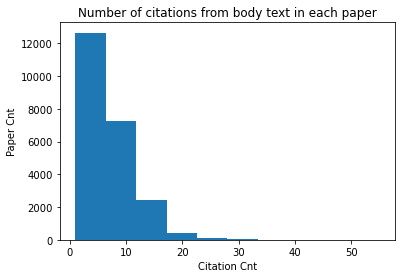

In [10]:
# number of citations in each paper from body text

body_counts = []
for paper_id in df.index:
    current_count = len(df.loc[paper_id, 'body_pairs'])
    body_counts.append(current_count)

plt.hist(body_counts)
plt.title('Number of citations from body text in each paper')
plt.xlabel('Citation Cnt')
plt.ylabel('Paper Cnt')
plt.show()

In [8]:
print("The minimum of citations in body text is", min(body_counts))
print("The maximum of citations in body text is", max(body_counts))
print('The average of citations in body text is', round(np.mean(body_counts)))

The minimum of citations in body text is 1
The maximum of citations in body text is 55
The average of citations in body text is 7


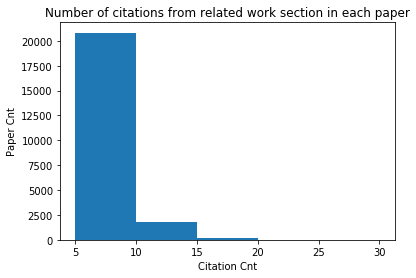

In [9]:
# number of citations in each paper from related work sections

related_work_counts = []
for paper_id in df.index:
    current_count = len(df.loc[paper_id, 'related_work_pairs'])
    related_work_counts.append(current_count)

plt.hist(related_work_counts, 5)
plt.title('Number of citations from related work section in each paper')
plt.xlabel('Citation Cnt')
plt.ylabel('Paper Cnt')
plt.show()

In [10]:
print("The minimum of citations in related work section is", min(related_work_counts))
print("The maximum of citations in related work section is", max(related_work_counts))
print('The average of citations in related work is', round(np.mean(related_work_counts)))

The minimum of citations in related work section is 5
The maximum of citations in related work section is 30
The average of citations in related work is 7


In [25]:
related_cite = [x for subset in df.related_work_pairs.apply(lambda x: list(x.keys())) for x in subset]
body_cite = [x for subset in df.body_pairs.apply(lambda x: list(x.keys())) for x in subset]
total_cite = set(related_cite+body_cite)

cite_count = sum([True for x in list(total_cite) if x in df.index])
        
cite_perc = (cite_count/df.shape[0])*100

print ('{0:.2f}% of cited papers appear in filtered dataset'.format(cite_perc))

18.78% of cited papers appear in filtered dataset


In [26]:
print('The number of papers in filtered dataset is', len(df))
print('The number of cited papers in filtered dataset is', cite_count)

The number of papers in filtered dataset is 22866
The number of cited papers in filtered dataset is 4294
